<a href="https://colab.research.google.com/github/razielsiegman/Movie-Recommender/blob/main/Recommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Setup

In [ ]:
!pip install turicreate

import pandas as pd
from turicreate import SFrame
import turicreate as tc
import numpy as np
import math
from sklearn.model_selection import train_test_split

     |████████████████████████████████| 92.0 MB 11 kB/s 
     |████████████████████████████████| 322 kB 10.2 MB/s 
     |████████████████████████████████| 3.5 MB 30.8 MB/s 
     |████████████████████████████████| 86.4 MB 45 kB/s 
     |████████████████████████████████| 3.6 MB 39.9 MB/s 
     |████████████████████████████████| 18.3 MB 1.9 MB/s 
     |████████████████████████████████| 2.9 MB 39.6 MB/s 
     |████████████████████████████████| 449 kB 10.8 MB/s 
     |████████████████████████████████| 20.1 MB 4.1 MB/s 
     |████████████████████████████████| 50 kB 4.3 MB/s 
     |████████████████████████████████| 3.8 MB 35.4 MB/s 
  Created wheel for prettytable: filename=prettytable-0.7.2-py3-none-any.whl size=13714 sha256=649a85465499a85c6c4369710399998b83c593c5be66cce3f80f7e4b501932f1
  Stored in directory: /root/.cache/pip/wheels/b2/7f/f6/f180315b584f00445045ff1699b550fa895d09471337ce21c6
  Created wheel for resampy: filename=resampy-0.2.1-py3-none-any.whl size=320859 sha256=2167d4cf91b

Load movielens data set, and drop the timestamp column, as it's arbitrary.

In [ ]:
df = pd.read_csv("http://files.grouplens.org/datasets/movielens/ml-100k/u1.base",sep='\t',header=None, names=["userId", "movieId", "rating", "timestamp"])
df.drop('timestamp', inplace=True, axis =1)

Perform basic data analysis, exploration, and cleaning.

In [ ]:
df.head(10)

,userId,movieId,rating
0,1,1,5
1,1,2,3
2,1,3,4
3,1,4,3
4,1,5,3
5,1,7,4
6,1,8,1
7,1,9,5
8,1,11,2
9,1,13,5


In [ ]:
df.describe()

,userId,movieId,rating
count,80000.00000,80000.000000,80000.000000
mean,525.16570,425.705200,3.528350
std,255.94956,331.383936,1.118565
min,1.00000,1.000000,1.000000
25%,334.00000,175.000000,3.000000
50%,535.00000,321.000000,4.000000
75%,744.00000,631.000000,4.000000
max,943.00000,1682.000000,5.000000


Although the highest movieId is 1682, the 50th percentile value is 321, and the 75th percentile value is 631.  Let's have a closer look at the movie Id and user Id distributions.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f83d1784d90>]],
      dtype=object)

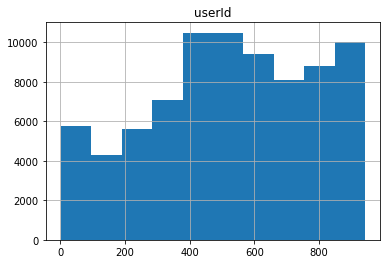

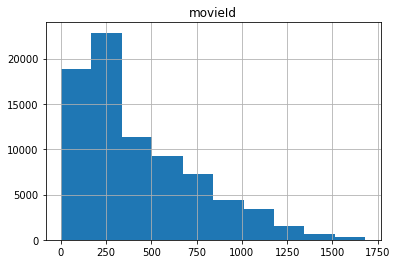

In [ ]:
df.hist(column = 'userId')
df.hist(column = 'movieId')

It does in fact seem that the robustness of the data set drops off significantly as movie Ids increase.  This is presumably because these movies are newer, and do not yet have as many reviews as older movies.  Let's drop data for very high movie Ids, to prevent their data sparsity from reducing the quality of the model.

In [ ]:
#Collect dataframe indices where the movieId is greater than 1200
indices_to_drop = df[df['movieId'] > 1200].index

# Delete these rows from the data
df.drop(indices_to_drop, inplace=True)

Let's have another look at the new distribution.

In [ ]:
df.describe()

,userId,movieId,rating
count,77731.000000,77731.000000,77731.000000
mean,524.553190,398.432080,3.548353
std,256.555418,293.774525,1.109512
min,1.000000,1.000000,1.000000
25%,334.000000,173.000000,3.000000
50%,535.000000,312.000000,4.000000
75%,743.000000,591.000000,4.000000
max,943.000000,1200.000000,5.000000


Although higher movie Ids still have less data, the highest Ids with extremely few data points have been removed.  Notably, although 482 movie Ids have been removed (as the new highest Id is 1200, as opposed to 1682), only 2,270 data points have been removed.  Therefore, on average, the removed movies had less than 5 reviews each, which is relatively small and could have skewed the model.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f83d167fbd0>]],
      dtype=object)

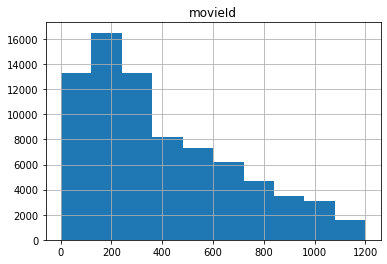

In [ ]:
df.hist(column = 'movieId')

A final data cleaning measure be taken.  Any movies that were rated less than 5 total times should be removed from the data set.  This is done for 2 reasons.  Firstly, movies there are a few movies that fall into this category, even with ids that are lower than 1200, and would decrease model performance with such a minimal amount of information known about them.  Furthermore, if this is not done, errors can arise where the matrix factorization embedding, which was created using the trained data, may not have certain entries for movies that were not a part of the train data, which was used to create the matrix factorization.

In [ ]:
df = df.groupby("movieId").filter(lambda i: len(i) >= 5)

Train-test-split the cleaned data, to create train, test, and validation data sets.  Note, that data is being split by user, to ensure that each data set has a proportional representation of data from all users.

Then, convert data to numpy arrays, to be used for baseline and hybrid model.

In [ ]:
data = SFrame(data=df)
train_sf, val_sf = tc.recommender.util.random_split_by_user(data, user_id = 'userId', item_id = 'movieId', item_test_proportion = .15, random_seed = 42)
train_sf, test_sf = tc.recommender.util.random_split_by_user(train_sf, user_id = 'userId', item_id = 'movieId', item_test_proportion = .15, random_seed = 42)

train_data = train_sf.to_numpy()
val_data = val_sf.to_numpy()
test_data = test_sf.to_numpy()

#Baseline

Compute baseline model to compare ML models against.  For the baseline model, first calculate the average of all movie ratings, and compare to actual ratings, computing root mean square error.

Being that the baseline model is not an ML model, and does not have any variability in training, produce one RMSE score based on the entire data set, as opposed train/test/val sets.

In [ ]:
all_data = df.to_numpy()
#Calculate average of all ratings
avg = np.average(all_data[:,2])
#Fill array with the computed avergae value
avg_arr = np.full(len(all_data[:]), avg)
#Calculte the differences between all actual values and average values, then square, and average the values.
mse = np.square(np.subtract(all_data[:,2], avg_arr)).mean()
#Take the square root of squared differences
rmse = math.sqrt(mse)
print("RMSE:")
print(rmse)


RMSE:
1.1082377559780345


There are very minimal discrepencies between the datasets, but overall, the baseline model produces an RMSE of aprox. 1.1

#Simple Model

Create a simple model using matrix factorization.  The user-movie rating matrix gets factorized into two matrices.  The important hyperparameter here is the number of factors, ultimately corresponding to the embedding vector size both for movies and users.

In [ ]:
mf_rec = tc.recommender.factorization_recommender.create(train_sf, user_id='userId', num_factors = 5, item_id='movieId', target='rating', random_seed = 42, verbose = 0)

To perform a model sanity check, view actual ratings vs ratings predicted by matrix factorization model.

In [ ]:
mf_predictions = mf_rec.predict(train_sf)
for i in range(0,10):
  print(f"Actual Value: {train_data[i,2]}  Predicted Value: {mf_predictions[i]}") 

Actual Value: 5  Predicted Value: 3.9989296676254096
Actual Value: 4  Predicted Value: 3.356408077630979
Actual Value: 3  Predicted Value: 2.397640410218221
Actual Value: 1  Predicted Value: 3.5659919263458075
Actual Value: 5  Predicted Value: 4.659063804302198
Actual Value: 5  Predicted Value: 4.608406233940107
Actual Value: 5  Predicted Value: 4.645344789478761
Actual Value: 5  Predicted Value: 4.083120036277753
Actual Value: 1  Predicted Value: 1.229718315753919
Actual Value: 4  Predicted Value: 3.978124227713627


In [ ]:
#Evaluate RMSE of model on training data
mf_rec.evaluate_rmse(train_sf, target = 'rating')

{'rmse_by_item': Columns:
 	movieId	int
 	rmse	float
 	count	int
 
 Rows: 1122
 
 Data:
 +---------+---------------------+-------+
 | movieId |         rmse        | count |
 +---------+---------------------+-------+
 |   118   |  0.7514512129374674 |  196  |
 |   660   |  0.664446925473571  |   90  |
 |   699   |  0.5931678553471817 |   53  |
 |   567   |  0.776164789630911  |   22  |
 |   773   | 0.29572660234375975 |   5   |
 |   1029  | 0.30747515208858445 |   9   |
 |   435   |  0.6326803185795813 |  111  |
 |   554   |  0.7815491786266966 |   48  |
 |   898   |  0.779419043405457  |   38  |
 |   840   |  0.7180887766929936 |   28  |
 +---------+---------------------+-------+
 [1122 rows x 3 columns]
 Note: Only the head of the SFrame is printed.
 You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.,
 'rmse_by_user': Columns:
 	userId	int
 	rmse	float
 	count	int
 
 Rows: 943
 
 Data:
 +--------+--------------------+-------+
 | userId |        rmse    

In [ ]:
#Evaluate RMSE of model on validation data
mf_rec.evaluate_rmse(val_sf, target = 'rating')

{'rmse_by_item': Columns:
 	movieId	int
 	rmse	float
 	count	int
 
 Rows: 1076
 
 Data:
 +---------+--------------------+-------+
 | movieId |        rmse        | count |
 +---------+--------------------+-------+
 |   118   | 0.7370072693825347 |   27  |
 |   660   | 0.8494909276657377 |   17  |
 |   699   | 0.9259751804601649 |   10  |
 |   567   | 0.8596350371606368 |   6   |
 |   773   | 1.0090002597904029 |   1   |
 |   1029  | 1.243524470840011  |   3   |
 |   435   | 1.0332758833455937 |   31  |
 |   554   | 1.1192293301900458 |   13  |
 |   898   | 1.6835605257366437 |   6   |
 |   840   | 0.7440298985492095 |   3   |
 +---------+--------------------+-------+
 [1076 rows x 3 columns]
 Note: Only the head of the SFrame is printed.
 You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.,
 'rmse_by_user': Columns:
 	userId	int
 	rmse	float
 	count	int
 
 Rows: 928
 
 Data:
 +--------+--------------------+-------+
 | userId |        rmse        | count |


Using 5 factors, I overall received the best results.  Although with even fewer factors, the validation data had very small imporovements in RMSE score, I wanted to make sure the embeddings were robust enough to be used in the neural net hybrid model.

Overall, the training data has a RMSE of .717, which is phenomenal, but there is clearly overfitting, as the validation data had an RMSE of 1.021.  Even this though, is better than the baseline model, which had an RMSE of about 1.1

Let's look at RMSE score on the testing data:

In [ ]:
mf_rec.evaluate_rmse(test_sf, target = 'rating')

{'rmse_by_item': Columns:
 	movieId	int
 	rmse	float
 	count	int
 
 Rows: 1047
 
 Data:
 +---------+--------------------+-------+
 | movieId |        rmse        | count |
 +---------+--------------------+-------+
 |   118   | 0.7119993458808479 |   17  |
 |   660   | 1.076608808788389  |   16  |
 |   699   | 1.3057217346314127 |   16  |
 |   567   | 4.4361470820045295 |   1   |
 |   773   | 1.5473070395716184 |   6   |
 |   435   | 0.7952785700332271 |   26  |
 |   554   | 1.231914720968132  |   12  |
 |   898   | 0.8717304552342696 |   7   |
 |   840   | 0.7855403600293213 |   8   |
 |   537   | 0.7939615594139832 |   8   |
 +---------+--------------------+-------+
 [1047 rows x 3 columns]
 Note: Only the head of the SFrame is printed.
 You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.,
 'rmse_by_user': Columns:
 	userId	int
 	rmse	float
 	count	int
 
 Rows: 920
 
 Data:
 +--------+---------------------+-------+
 | userId |         rmse        | count 

The testing data had aprox. the same results as the validation data, with an RMSE of 1.018

Using the matrix factorization, we can view movies that are deemed most similar.  The following turicreate method provides the 10 most similar movies for each movie in the dataset.  A higher score is better, and the scores are based off of cosine similarity between latent movie matrix factors.

In [ ]:
mf_rec.get_similar_items().print_rows(num_rows=30)

+---------+---------+--------------------+------+
| movieId | similar |       score        | rank |
+---------+---------+--------------------+------+
|    1    |   202   | 0.9829190373420715 |  1   |
|    1    |   832   | 0.9653711915016174 |  2   |
|    1    |   620   | 0.9281880259513855 |  3   |
|    1    |   172   | 0.9172412157058716 |  4   |
|    1    |   1181  | 0.9135940670967102 |  5   |
|    1    |   403   | 0.9074235558509827 |  6   |
|    1    |   572   | 0.9020295739173889 |  7   |
|    1    |   952   | 0.8907140493392944 |  8   |
|    1    |   174   | 0.8867518901824951 |  9   |
|    1    |   181   | 0.8811113238334656 |  10  |
|    3    |    33   | 0.9381273984909058 |  1   |
|    3    |   665   | 0.9258729815483093 |  2   |
|    3    |   260   | 0.9209964275360107 |  3   |
|    3    |    59   | 0.9148467183113098 |  4   |
|    3    |   512   | 0.9138672351837158 |  5   |
|    3    |   326   | 0.9130807518959045 |  6   |
|    3    |   773   | 0.9115629196166992 |  7   |


We can do the same as above to view similar users:

In [ ]:
mf_rec.get_similar_users().print_rows(num_rows=30)

Getting similar users completed in 0.019759

+--------+---------+--------------------+------+
| userId | similar |       score        | rank |
+--------+---------+--------------------+------+
|   1    |   397   | 0.9889780879020691 |  1   |
|   1    |   527   | 0.9840924739837646 |  2   |
|   1    |   448   | 0.9826240539550781 |  3   |
|   1    |   903   | 0.962834358215332  |  4   |
|   1    |   267   | 0.9463540315628052 |  5   |
|   1    |   669   | 0.936616063117981  |  6   |
|   1    |   664   | 0.9362205266952515 |  7   |
|   1    |    2    | 0.9226730465888977 |  8   |
|   1    |   308   | 0.9224660396575928 |  9   |
|   1    |   829   | 0.9164837002754211 |  10  |
|   2    |   490   | 0.9557328224182129 |  1   |
|   2    |   448   | 0.9408483505249023 |  2   |
|   2    |   933   | 0.9402737617492676 |  3   |
|   2    |   730   | 0.9357120394706726 |  4   |
|   2    |   527   | 0.9324018359184265 |  5   |
|   2    |    1    | 0.9226730465888977 |  6   |
|   2    |   892   | 0.9182469248771667 |  7   |
|   2    |   397   |

As the last step in the simple model, load the matrices for the users and movies, which will be used as the embeddings in the hybrid model.

In [ ]:
user_coef = mf_rec.coefficients['userId']
user_coef_sf = user_coef.sort('userId')
user_coef = user_coef_sf.to_numpy()

movie_coef = mf_rec.coefficients['movieId']
movie_coef_sf = movie_coef.sort('movieId')
movie_coef = movie_coef_sf.to_numpy()


/usr/local/lib/python3.7/dist-packages/turicreate/data_structures/sframe.py:2616: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return numpy.transpose(numpy.asarray([self[x] for x in self.column_names()]))


#Hybrid

In [ ]:
#Update tensorflow to the newest version (turicreate runs on an older version)
!pip install -U tensorflow

#Neural Net Imports
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.optimizers import SGD
from keras import metrics
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt


     |████████████████████████████████| 511.7 MB 2.8 kB/s 
     |████████████████████████████████| 438 kB 53.0 MB/s 
     |████████████████████████████████| 5.8 MB 42.7 MB/s 
     |████████████████████████████████| 1.6 MB 27.9 MB/s 
     |████████████████████████████████| 15.7 MB 215 kB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.18.5
    Uninstalling numpy-1.18.5:
      Successfully uninstalled numpy-1.18.5
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.0.1
    Uninstalling tensorflow-estimator-2.0.1:
      Successfully uninstalled tensorflow-estimator-2.0.1
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.0.2
    Uninstalling tensorboard-2.0.2:
      Successfully uninstalled tensorboard-2.0.2
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0
  Attempting uninstall: flatbu

For the hybrid model, I am taking the user and movie latent factors from the matrix factorization model, and using them as embeddings into a neural network.  The first step is to use the matrices retrieved above to create the embeddings for each dataset.

In [ ]:
#function to create embeddings to be inputted to neural net
def createEmbedding(data):
  movie_embedding = []
  user_embedding = []
  concat_embedding = []
  for row in data:
    movie_id = row[1]
    user_id = row[0]
    #find the row in the coefficient matrix for the given movie id, and append the latent factors to the movie_embedding matrix
    movie_coef_index = np.where(movie_coef[:,0]==movie_id)
    movie_embedding.append(movie_coef[movie_coef_index[0][0]][2])
    #similarly, append latent factors for given user to user_embedding matrix
    user_embedding.append(user_coef[user_id-1][2])
  movie_embedding = np.asarray(movie_embedding)
  user_embedding = np.asarray(user_embedding)
  #create one embedding matrix, with movie and user embeddings concatenated together
  concat_embedding = np.concatenate((movie_embedding, user_embedding), axis=1)
  return concat_embedding

#retrieve train, val and test embeddings
train_embedding = createEmbedding(train_data)
val_embedding = createEmbedding(val_data)
test_embedding = createEmbedding(test_data)


Build a neural network, with the input being the embeddings from the matrix factorization

In [ ]:
model = Sequential()
#Add relu layers with decreasing amount of neurons
model.add(Dense(128, input_dim=10, activation='relu'))
#Use dropout to limit overlearning
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(8, activation='relu'))
model.add(Dense(1))
#SGD optimizer (with a low learning rateperformed better than Adam
sgd_opt = SGD(learning_rate=.0041, name="SGD")
model.compile(optimizer = sgd_opt, loss='mse', metrics=[metrics.RootMeanSquaredError()])
history = model.fit(x=train_embedding, y=train_data[:,2], epochs=6, verbose=2, batch_size = 100, validation_data=(val_embedding, val_data[:,2]))

Epoch 1/6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing th

As displayed above, as well as in the plots of the loss and RMSE below, althought the dropout layers prevented extreme overfitting, some overfitting nevertheless exists.

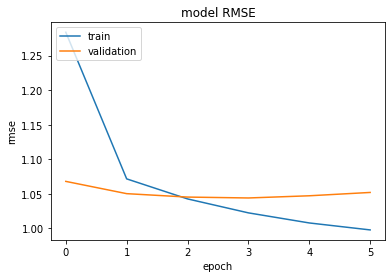

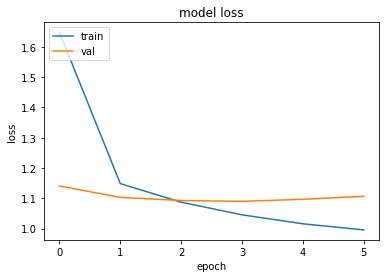

In [ ]:
#plot code based on
#https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/

# summarize history for rmse
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model RMSE')
plt.ylabel('rmse')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Compute the hybrid models's RMSE scores.  Interestingly, the hybrid model performed slightly worse than the simple model.


In [ ]:
#Retrieve the predictions from model
train_predictions = model.predict(train_embedding)

#Compute RMSE between actual values and model's predictions
#When the squared parameter is false, the RMSE is computed
print(f"/nTrain RMSE: {mean_squared_error(train_data[:,2], train_predictions, squared = False)}\n")

#Do the same for val, and then test data
val_predictions = model.predict(val_embedding)
print(f"Validation RMSE: {mean_squared_error(val_data[:,2], val_predictions, squared = False)}\n")

test_predictions = model.predict(test_embedding)
print(f"Test RMSE: {mean_squared_error(test_data[:,2], test_predictions, squared = False)}")

1751/1751 [==============================] - 11s 7ms/step
/nTrain RMSE: 0.9520818579693145

364/364 [==============================] - 3s 9ms/step
Validation RMSE: 1.0519540413256552

309/309 [==============================] - 3s 9ms/step
Test RMSE: 1.05598381243121


#Final Validation

Load the final testing set.

In [ ]:
final_test_df = pd.read_csv("http://files.grouplens.org/datasets/movielens/ml-100k/u1.test",sep='\t',header=None, names=["userId", "movieId", "rating", "timestamp"])
final_test_df.drop('timestamp', inplace=True, axis =1)

In the initial dataset, movies with an id higher than 1200 were dropped, as well as all other movies with less than 5 datapoints.  To easily determine movies than were used, and which thus have embeddings to be tested with, view the first column of the movie embedding list.  Any Id not present there will be removed from the final testing data.

In [ ]:
embedding_list= movie_coef[:,0]
final_test_df = final_test_df[final_test_df.movieId.isin(embedding_list)]
final_test_data = final_test_df.to_numpy()

In [ ]:
#Evaluate RMSE of final test data on simple model

final_test_sf = SFrame(data=final_test_df)

mf_rec.evaluate_rmse(final_test_sf, target = 'rating')

{'rmse_by_item': Columns:
 	movieId	int
 	rmse	float
 	count	int
 
 Rows: 1104
 
 Data:
 +---------+--------------------+-------+
 | movieId |        rmse        | count |
 +---------+--------------------+-------+
 |   118   | 0.970467270442791  |   53  |
 |   660   | 0.9554967500180628 |   30  |
 |   699   |  1.09095459661659  |   23  |
 |   567   | 2.5192362310412055 |   6   |
 |   773   | 0.6274033625455666 |   5   |
 |   1029  | 1.1615855962151849 |   2   |
 |   435   | 0.9226240320162616 |   48  |
 |   554   | 0.9635494787249177 |   29  |
 |   898   | 0.6948802610045155 |   7   |
 |   840   | 1.3671765374875553 |   14  |
 +---------+--------------------+-------+
 [1104 rows x 3 columns]
 Note: Only the head of the SFrame is printed.
 You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.,
 'rmse_by_user': Columns:
 	userId	int
 	rmse	float
 	count	int
 
 Rows: 459
 
 Data:
 +--------+--------------------+-------+
 | userId |        rmse        | count |


In [ ]:
#Evaluate RMSE of final test data on hybrid model


final_test_embedding = createEmbedding(final_test_data)
final_test_predictions = model.predict(final_test_embedding)
print(f"Validation RMSE: {mean_squared_error(final_test_data[:,2], final_test_predictions, squared = False)}")

606/606 [==============================] - 4s 7ms/step
Validation RMSE: 1.0697348123265387



Final Results:


*   Baseline Model:  1.1



Here are the final results for the simple and hybrid models, respectively:



*   Train: .717;  .952
*   Validation: 1.021;  1.052
*   Test: 1.018;  1.056
*   Final Test: 1.049;  1.070






